In [3]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import matplotlib.patches as mpatches

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "-",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}
color1 = sns.color_palette("deep")[0]
color2 = sns.color_palette("deep")[1]

### Data Analysis

In [5]:
from datasets import load_dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

model_name_or_path = "microsoft/DialoGPT-large"
# config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name_or_path, config=config)

datasets = load_dataset('data/Anthropic')
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['query'], 
        padding=False, 
        truncation=True,
    )
    labels = tokenizer(
        examples['reference'], 
        padding=False, 
        truncation=True,
    )
    tokenized_inputs['labels'] = labels['input_ids']
    # tokenized_inputs['labels_attention_mask'] = labels['attention_mask']
    return tokenized_inputs

test_dataset = datasets['test'].map(
    tokenize_and_align_labels,
    batched=True,
).remove_columns(datasets['test'].column_names)

/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yuli/.conda/envs/py3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Mean: 94.83808200138985, Std: 103.116699419495, Medium: 61.0


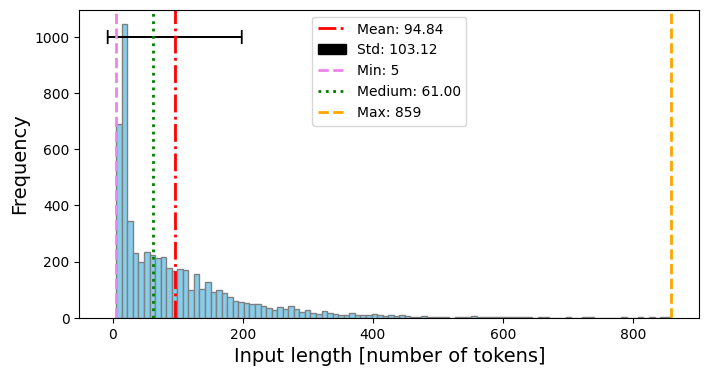

In [7]:
input_lengths = [len(x) for x in test_dataset['input_ids']]
mean, std, medium = np.mean(input_lengths), np.std(input_lengths), np.median(input_lengths)
print(f"Mean: {mean}, Std: {std}, Medium: {medium}")

plt.figure(figsize=(8, 4))
plt.hist(input_lengths, bins=100, color='skyblue', edgecolor='gray')
plt.axvline(mean, color='r', linestyle='-.', linewidth=2, label=f'Mean: {mean:.2f}') # mean as red vertical lin
# standard deviation as two horizontal arrows with length of std starting from mean
plt.arrow(mean, 1000, std, 0, head_width=50, head_length=0.02, fc='black', ec='black', label=f'Std: {std:.2f}')
plt.arrow(mean, 1000, -std, 0, head_width=50, head_length=0.02, fc='black', ec='black')
plt.axvline(min(input_lengths), color='violet', linestyle='--', linewidth=2, label=f'Min: {min(input_lengths)}') # min as blue vertical line
plt.axvline(medium, color='g', linestyle='dotted', linewidth=2, label=f'Medium: {medium:.2f}') # medium as green vertical line
plt.axvline(max(input_lengths), color='orange', linestyle='--', linewidth=2, label=f'Max: {max(input_lengths)}') # max as blue vertical line
plt.xlabel('Input length [number of tokens]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
# plt.savefig('figure/input_length_distribution.pdf', bbox_inches='tight')
plt.show()

In [8]:
def _sample_subset_indices(input_lengths: List[int], K: int, mu: float, std: float) -> List[int]:
    # Create an empty list to store the selected numbers
    selected_ids = set()
    lengths_dict = {} # {length: [idx1, idx2, ...]}
    for idx, length in enumerate(input_lengths):
        if length not in lengths_dict:
            lengths_dict[length] = [idx]
        else:
            lengths_dict[length].append(idx)

    # We draw K samples from the normal distribution
    for _ in range(K):
        sample = np.random.normal(mu, std)
        if sample in lengths_dict:
            selected_ids.add(lengths_dict[sample][0])
            lengths_dict[sample].pop(0) # pop the selected index
            if len(lengths_dict[sample]) == 0:
                del lengths_dict[sample]
        else:
            # Find the number in 'numbers' that is closest to the sampled number
            closest_number = min(list(lengths_dict.keys()), key=lambda x: abs(x - sample))
            selected_ids.add(lengths_dict[closest_number][0])
            lengths_dict[closest_number].pop(0)
            if len(lengths_dict[closest_number]) == 0:
                del lengths_dict[closest_number]
        
    return selected_ids

K = 1000
subset_ids = _sample_subset_indices(input_lengths, K, mean, 0)
subset_lengths = [input_lengths[idx] for idx in subset_ids]
print(len(subset_ids) == K) # check repeated numbers
new_mean, new_std, new_medium = np.mean(subset_lengths), np.std(subset_lengths), np.median(subset_lengths)
print(f"Mean: {new_mean}, Std: {new_std}, Medium: {new_medium}")

True
Mean: 92.914, Std: 13.906135480427336, Medium: 93.0


### Section 2.2 Mixtraining is useful

In [13]:
# def plot_box(
#     label1='Separate', 
#     label2='NaiveMix', 
#     priority='FIFO', 
#     load_balancing='random', 
#     num_nodes=2, 
#     models=['DialoGPT-small', 'DialoGPT-medium', 'DialoGPT-large'], 
#     length_heterogeneity=None,
#     active_selection=None,
#     length_distribution='random',
#     lambda_ = 10,
#     retrain_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     legend = True,
# ):
#     data = []
#     res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
#     length_distribution = f'{length_distribution}-_hetero{length_heterogeneity}' if length_heterogeneity is not None else length_distribution
    
#     for retrain_rate in retrain_rates:
#         for model in models:
#             # Separate
#             res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{retrain_rate}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
#             res["retrain_rate"] = retrain_rate
#             res["model"] = model
#             res['method'] = label1
#             data.append(res)
#             # Mixtraining
#             res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}-{priority}_poisson-{length_distribution}_{retrain_rate}.json"))
#             res["retrain_rate"] = retrain_rate
#             res["model"] = model
#             res['method'] = label2
#             data.append(res)
        
#     data = pd.DataFrame(data)
#     os.makedirs("figure", exist_ok=True)

#     # Four metrics in subplots
#     fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
#     methods = data['method'].unique().tolist()
#     metrics = ['loss', 'end2end_latency', 'idles', 'user_response']
#     colors = ['peachpuff', 'lightsteelblue']  # Using only two methods
#     # colors = [color1, color2]
#     hatches = ['/', 'x']  # Using only two methods
#     legend_patches = [mpatches.Patch(facecolor=colors[i], 
#                                      hatch=hatches[i], 
#                                      edgecolor='black', 
#                                      label=method) for i, method in enumerate(methods)]

#     for metric, ax in zip(metrics, axes):
#         for i, (retrain_rate, group_data) in enumerate(data.groupby('retrain_rate')):
#             positions = [i + offset*0.3 for offset in range(len(methods))]
#             for method in methods:
#                 method_data = group_data[group_data['method'] == method][metric].values
#                 box = ax.boxplot(method_data, 
#                                  positions=[positions[methods.index(method)]], 
#                                  widths=0.3, 
#                                  patch_artist=True,
#                                  boxprops=dict(facecolor=colors[methods.index(method)], 
#                                                hatch=hatches[methods.index(method)]),
#                                  medianprops=dict(color='black'),
#                                  whiskerprops=dict(color='black'),
#                                  capprops=dict(color='black'),
#                                  showfliers=False)
#         ax.set_xticks([i + 0.3 for i in range(len(retrain_rates))])
#         ax.set_xticklabels(retrain_rates)
#         ax.set_xlabel("Retrain rate", fontsize=14)
#         ax.set_ylabel(METRIC2NAME[metric], fontsize=14)  # Make sure METRIC2NAME is defined before using

#     if legend:
#         fig.legend(handles=legend_patches, loc='upper center', ncol=len(methods), fontsize='large', bbox_to_anchor=(0.5, 1.1))
        
#     plt.tight_layout()
#     plt.savefig(f'figure/2-2-nodes={num_nodes}_lambda={lambda_}.pdf', bbox_inches='tight')
#     plt.show()

In [30]:
METRIC2NAME = {
    'losses': 'Loss',
    'end2end_latency': 'Runtime [s]',
    'bubble_rate': 'Bubble rate',
    'user_responses': 'Response [ms]',
}

def plot_box(
    label1='Separate', 
    label2='NaiveMix', 
    priority='FIFO', 
    load_balancing='random', 
    num_nodes=2, 
    model='DialoGPT-small', 
    length_heterogeneity=None,
    length_distribution='random',
    lambda_ = 10,
    retrain_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    legend = True,
):
    data = []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    length_distribution = f'{length_distribution}-_hetero{length_heterogeneity}' if length_heterogeneity is not None else length_distribution
    
    for retrain_rate in retrain_rates:
        # Separate
        res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}-split{retrain_rate}-{priority}_poisson-_hetero_default-{length_distribution}_{retrain_rate}-_active_1.0.json"))
        res["retrain_rate"] = retrain_rate
        res['method'] = label1
        data.append(res)
        # Mixtraining
        res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}-{priority}_poisson-_hetero_default-{length_distribution}_{retrain_rate}-_active_1.0.json"))
        res["retrain_rate"] = retrain_rate
        res['method'] = label2
        data.append(res)
        
    data = pd.DataFrame(data)
    os.makedirs("figure", exist_ok=True)

    # Four metrics in subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
    methods = data['method'].unique().tolist()
    metrics = ['losses', 'end2end_latency', 'bubble_rate', 'user_responses']
    colors = ['peachpuff', 'lightsteelblue']  # Using only two methods
    # colors = [color1, color2]
    hatches = ['/', 'x']  # Using only two methods
    legend_patches = [mpatches.Patch(facecolor=colors[i], 
                                     hatch=hatches[i], 
                                     edgecolor='black', 
                                     label=method) for i, method in enumerate(methods)]

    for metric, ax in zip(metrics, axes):
        for i, (retrain_rate, group_data) in enumerate(data.groupby('retrain_rate')):
            positions = [i + offset*0.3 for offset in range(len(methods))]
            for method in methods:
                method_data = group_data[group_data['method'] == method][metric].values
                if metric == 'end2end_latency' or metric == 'bubble_rate':
                    # Use barplot instead as it is one point
                    ax.bar(positions[methods.index(method)], 
                           np.mean(method_data), 
                           width=0.3, 
                           color=colors[methods.index(method)], 
                           hatch=hatches[methods.index(method)],
                           # define black borders
                           edgecolor='black')
                else:
                    ax.boxplot(method_data, 
                               positions=[positions[methods.index(method)]], 
                               widths=0.3, 
                               patch_artist=True,
                               boxprops=dict(facecolor=colors[methods.index(method)], 
                                             hatch=hatches[methods.index(method)]),
                               medianprops=dict(color='black'),
                               whiskerprops=dict(color='black'),
                               capprops=dict(color='black'),
                               showfliers=False)
        ax.set_xticks([i + 0.3 for i in range(len(retrain_rates))])
        ax.set_xticklabels(retrain_rates)
        ax.set_xlabel("Retraining rate "+r'$\alpha$', fontsize=14)
        ax.set_ylabel(METRIC2NAME[metric], fontsize=14)  # Make sure METRIC2NAME is defined before using

    if legend:
        fig.legend(handles=legend_patches, loc='upper center', ncol=len(methods), fontsize='x-large', bbox_to_anchor=(0.5, 1.1))
        
    plt.tight_layout()
    plt.savefig(f'figure/2-2-{model}_nodes={num_nodes}_lambda={lambda_}.pdf', bbox_inches='tight')
    plt.show()

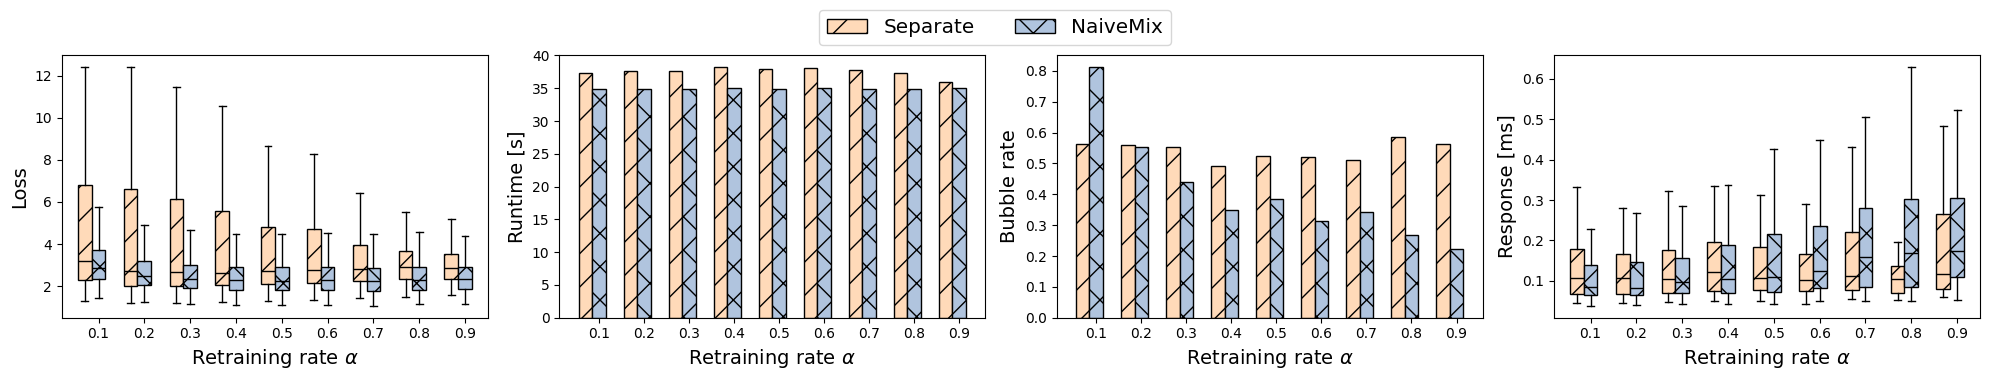

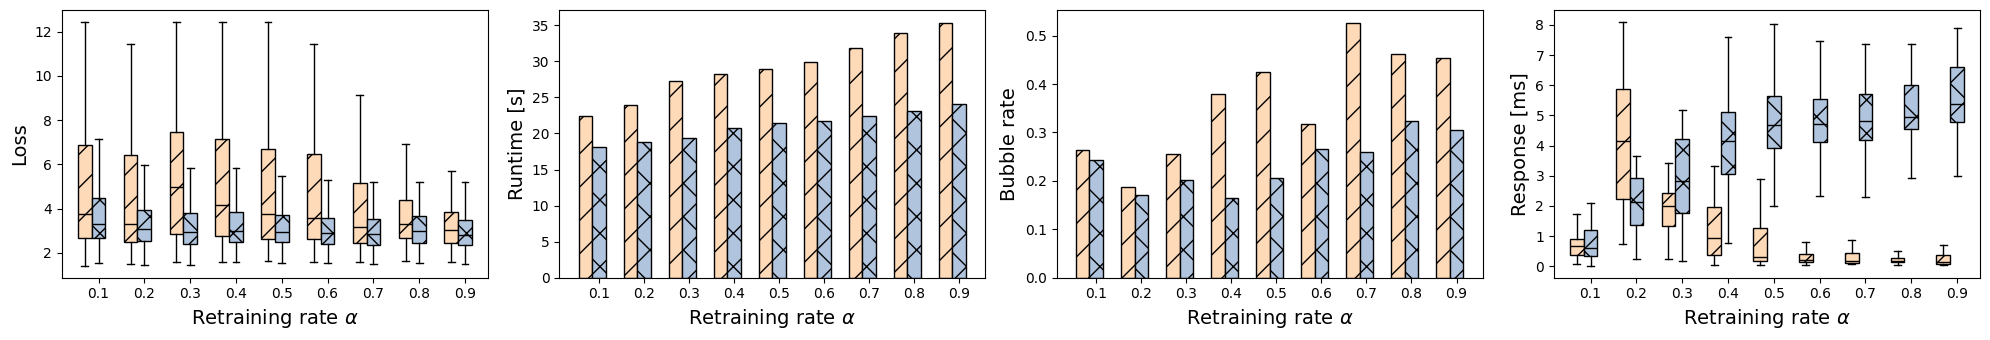

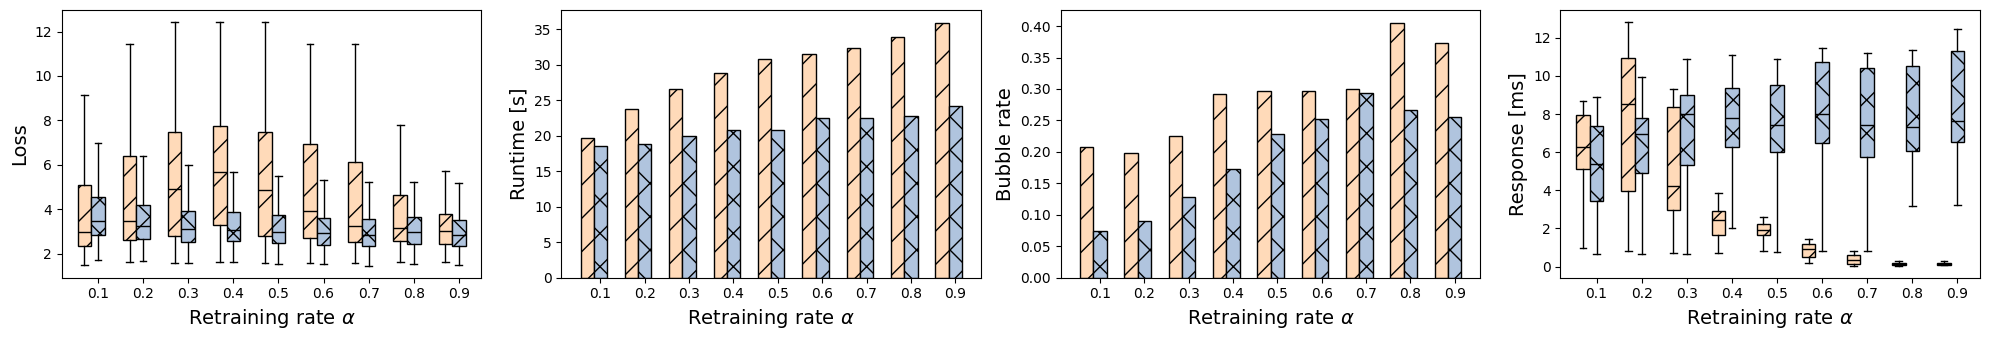

In [31]:
plot_box(model='DialoGPT-large', num_nodes=2, lambda_=10)
plot_box(model='DialoGPT-large', num_nodes=2, lambda_=20, legend=False)
plot_box(model='DialoGPT-large', num_nodes=2, lambda_=30, legend=False)

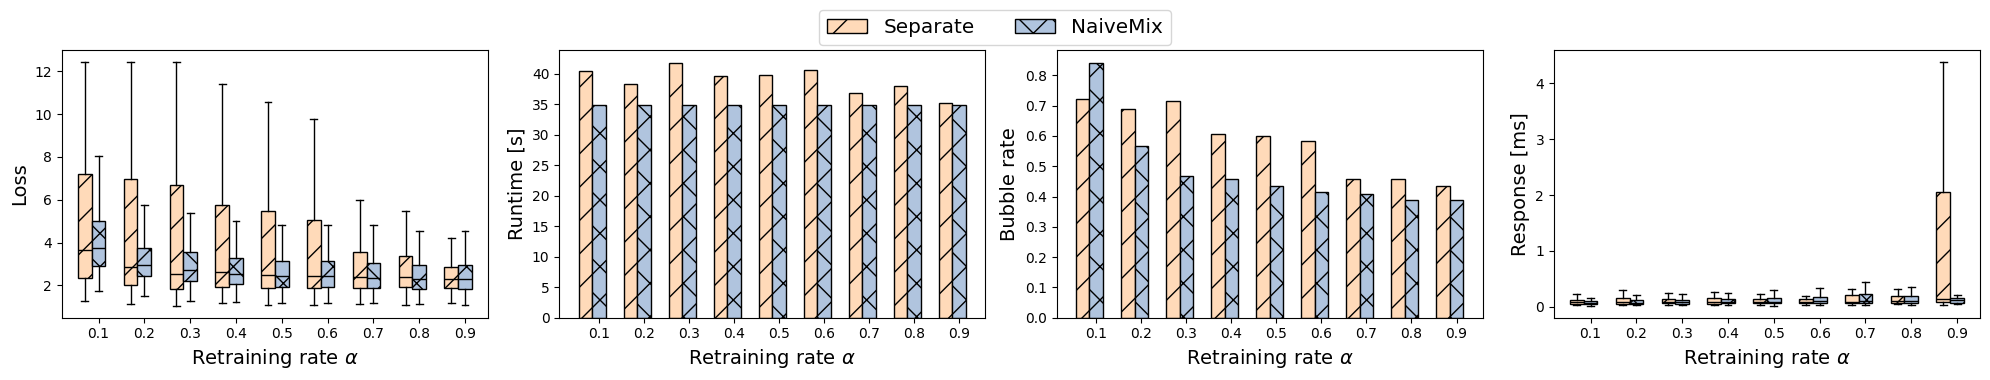

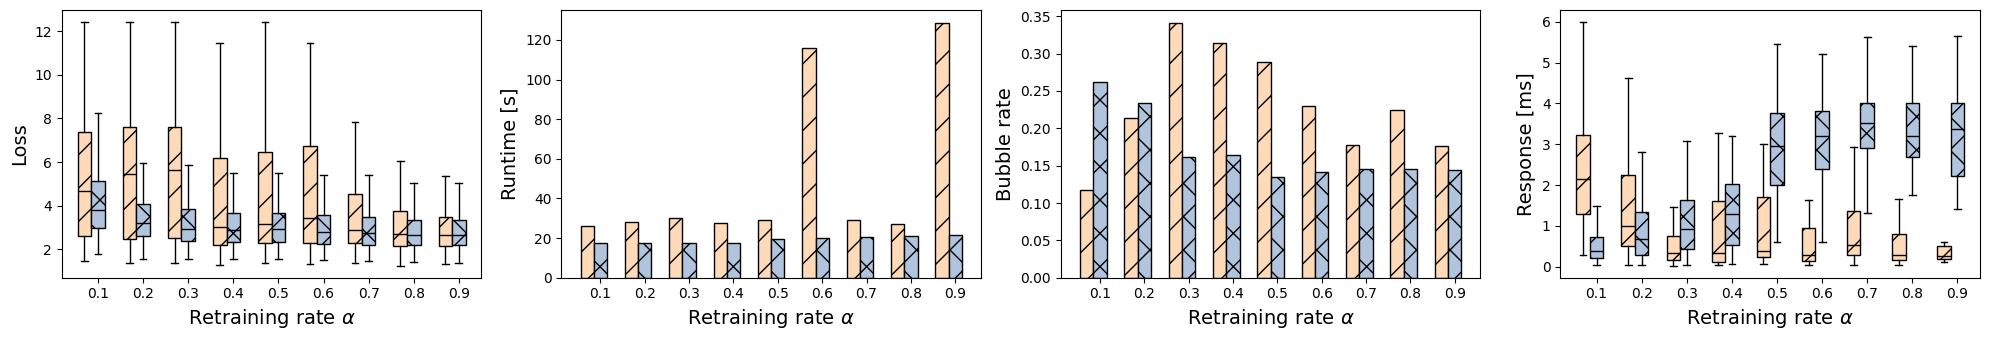

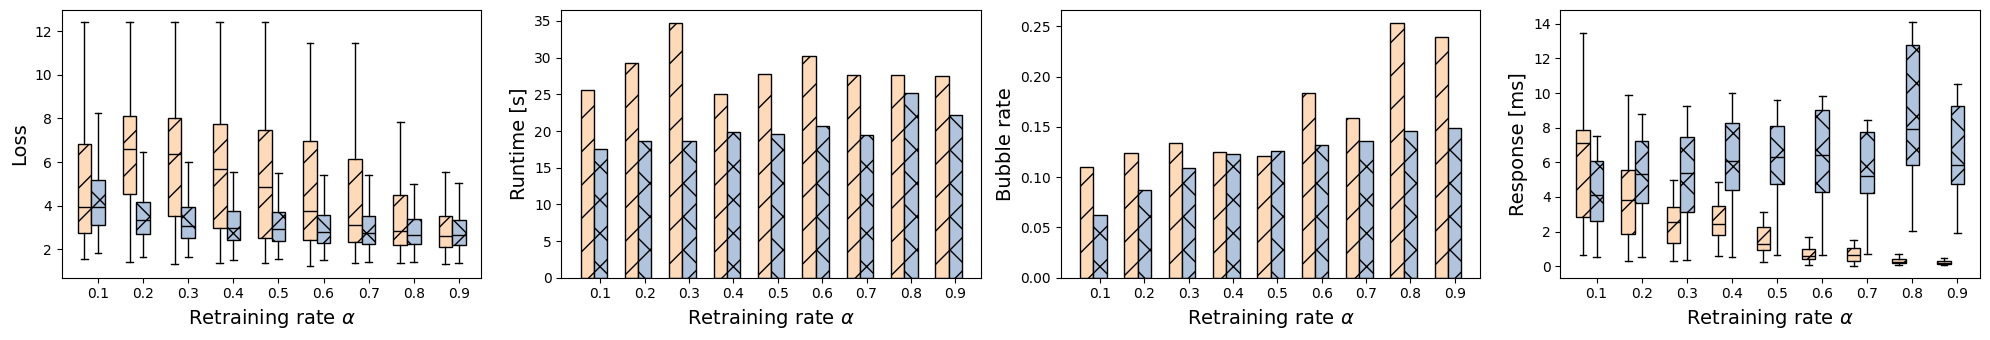

In [32]:
plot_box(model='DialoGPT-large', num_nodes=4, lambda_=10)
plot_box(model='DialoGPT-large', num_nodes=4, lambda_=20, legend=False)
plot_box(model='DialoGPT-large', num_nodes=4, lambda_=30, legend=False)

### Section 2.3 Optimization opportunity

In [42]:
def plot_length_heterogeneity(
    label='NaiveMix',  # 'Separate', 
    priority='FIFO', 
    load_balancing='random', 
    num_nodes=2, 
    model='DialoGPT-small', 
    length_heterogeneities=[0, 200],
    active_selection=None,
    length_distributions=['random', 'ascending', 'descending', 'bursty'],
    lambda_ = 10,
    retrain_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    legend = True,
):
    data = []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    active_selection = f"_active{active_selection}" if active_selection is not None else "_active_1.0"
    for retrain_rate in retrain_rates:
        for l_h in length_heterogeneities: # sigma
            if l_h != 0:
                for length_distribution in length_distributions:
                    try:
                        res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-{priority}_poisson-_hetero{l_h}-{length_distribution}_{retrain_rate}-{active_selection}.json"))
                    except:
                        res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-split{retrain_rate}-{priority}_poisson-_hetero{l_h}-{length_distribution}_{retrain_rate}-{active_selection}.json"))
                    res["retrain_rate"] = retrain_rate
                    res["Length variance"] = f'{l_h}-{length_distribution}'
                    data.append(res)
            else:
                try:
                    res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-{priority}_poisson-_hetero{l_h}-random_{retrain_rate}-{active_selection}.json"))
                except:
                    res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-split{retrain_rate}-{priority}_poisson-_hetero{l_h}-random_{retrain_rate}-{active_selection}.json"))
                res["retrain_rate"] = retrain_rate
                res["Length variance"] = '0'
                data.append(res)
        
    data = pd.DataFrame(data)
    os.makedirs("figure", exist_ok=True)

    # Four metrics in subplots
    fig, axes = plt.subplots(1, 4, figsize=(25, 3.5))
    metrics = ['losses', 'end2end_latency', 'bubble_rate', 'user_responses']
    colors = ['white', 'lightgray', 'darkgray', 'gray', 'black']  # Using only two methods
    methods = data["Length variance"].unique().tolist()
    hatches = ['/', 'x', '\\', '+', '.']  # Using only two methods
    legend_patches = [mpatches.Patch(facecolor=colors[i], 
                                     hatch=hatches[i], 
                                     edgecolor='black', 
                                     label=r"$\sigma=$"+f"{variance}") for i, variance in enumerate(methods)]

    for metric, ax in zip(metrics, axes):
        for i, (retrain_rate, group_data) in enumerate(data.groupby('retrain_rate')):
            positions = [i + offset*0.15 for offset in range(len(methods))]
            for variance in methods:
                variance_data = group_data[group_data['Length variance'] == variance][metric].values
                if metric == 'end2end_latency' or metric == 'bubble_rate':
                    # Use barplot instead as it is one point
                    ax.bar(positions[methods.index(variance)], 
                           np.mean(variance_data), 
                           width=0.15, 
                           color=colors[methods.index(variance)], 
                           hatch=hatches[methods.index(variance)],
                           # define black borders
                           edgecolor='black')
                else:
                
                    ax.boxplot(variance_data, 
                               positions=[positions[methods.index(variance)]], 
                               widths=0.15, 
                               patch_artist=True,
                               boxprops=dict(facecolor=colors[methods.index(variance)], 
                                             hatch=hatches[methods.index(variance)]),
                               medianprops=dict(color='black'),
                               whiskerprops=dict(color='black'),
                               capprops=dict(color='black'),
                               showfliers=False)
        ax.set_xticks([i + 0.15 for i in range(len(retrain_rates))])
        ax.set_xticklabels(retrain_rates)
        ax.set_xlabel("Retrain rate", fontsize=14)
        ax.set_ylabel(METRIC2NAME[metric], fontsize=14)  # Make sure METRIC2NAME is defined before using

    if legend:
        fig.legend(handles=legend_patches, loc='upper center', ncol=len(methods), fontsize='xx-large', bbox_to_anchor=(0.5, 1.15))
        
    plt.tight_layout()
    # hetero = length_heterogeneity.lstrip("_hetero")
    active = active_selection.lstrip("_active")
    plt.savefig(f'figure/2-3-{model}_method={label}_nodes={num_nodes}_lambda={lambda_}_select={active}.pdf', bbox_inches='tight')
    plt.show()

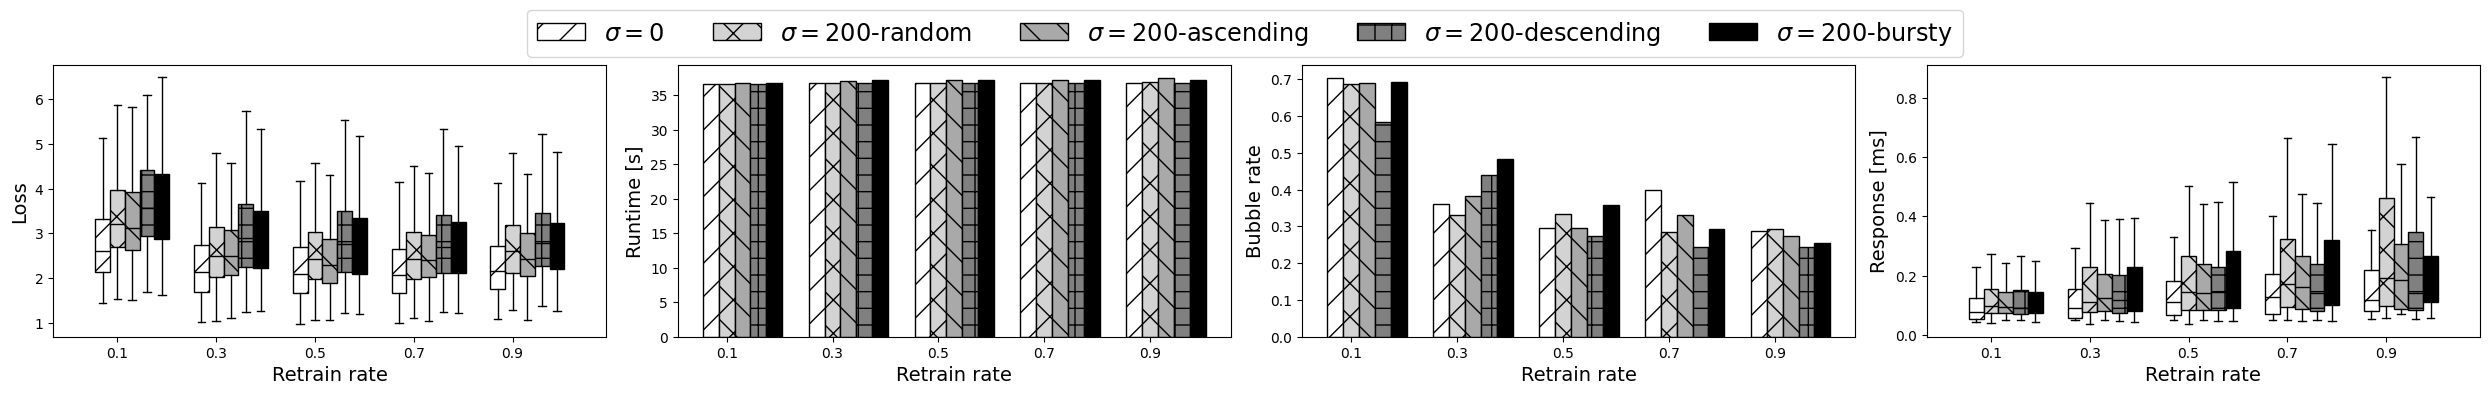

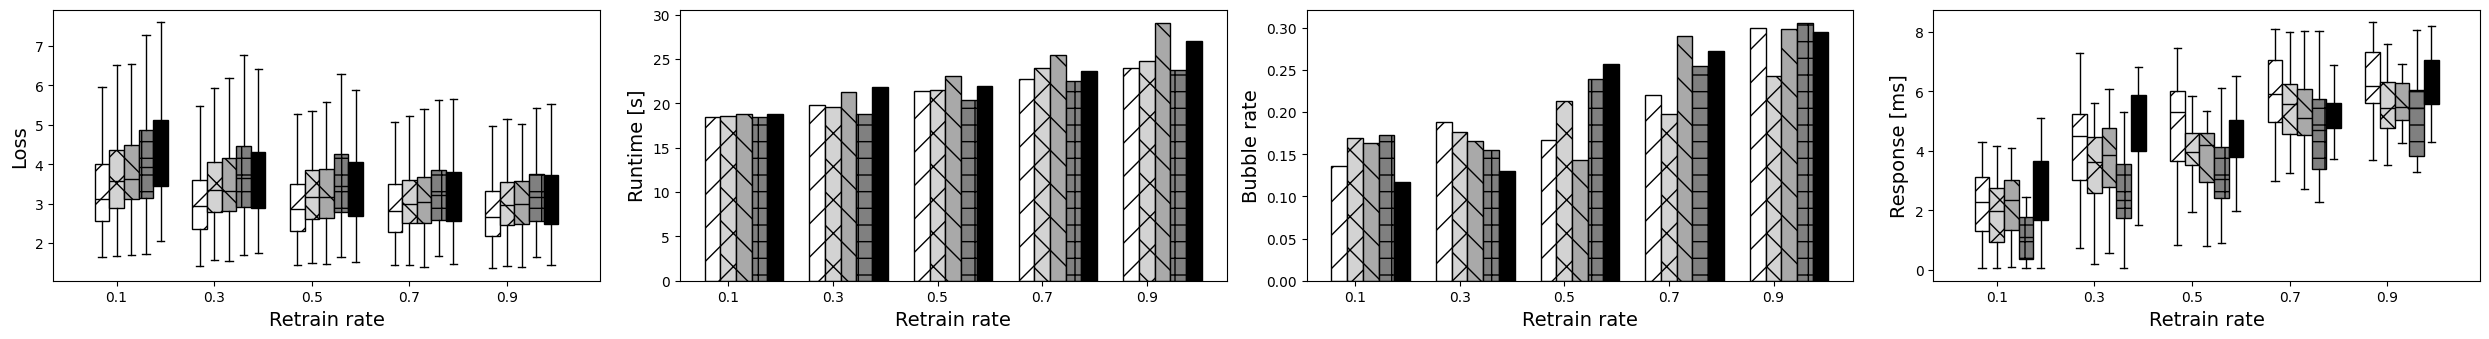

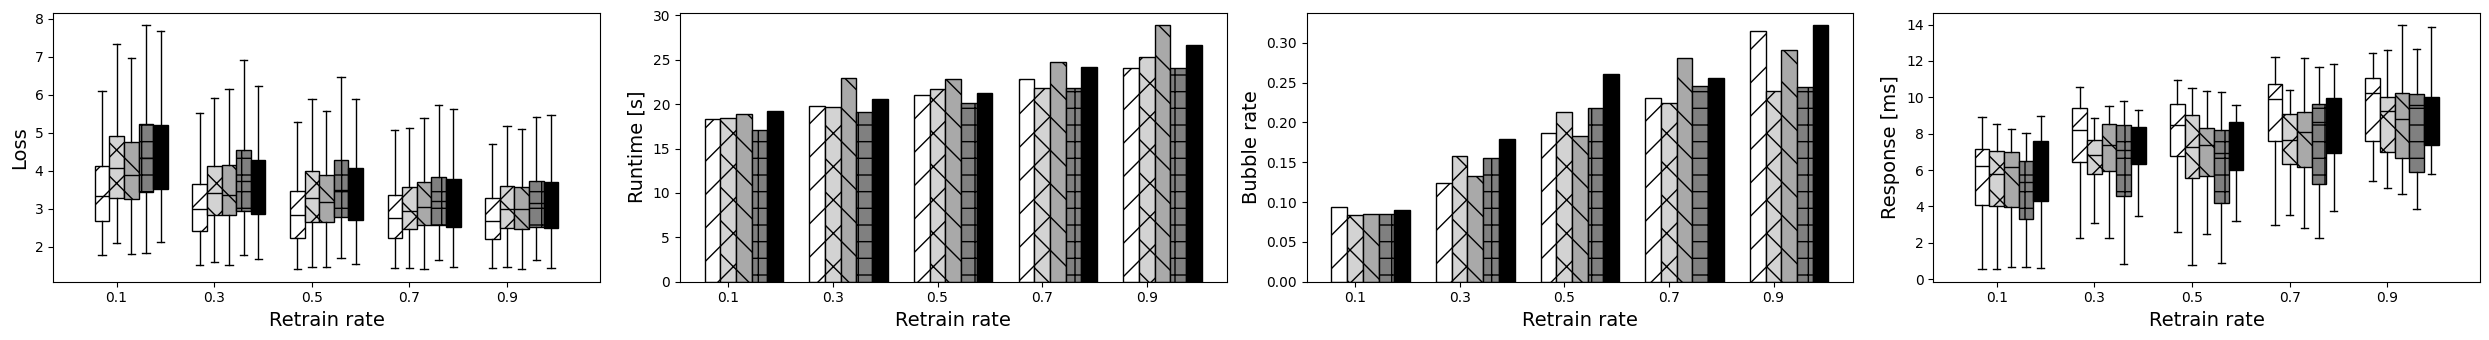

In [43]:
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=2, lambda_=10, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9])
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=2, lambda_=20, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=2, lambda_=30, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)

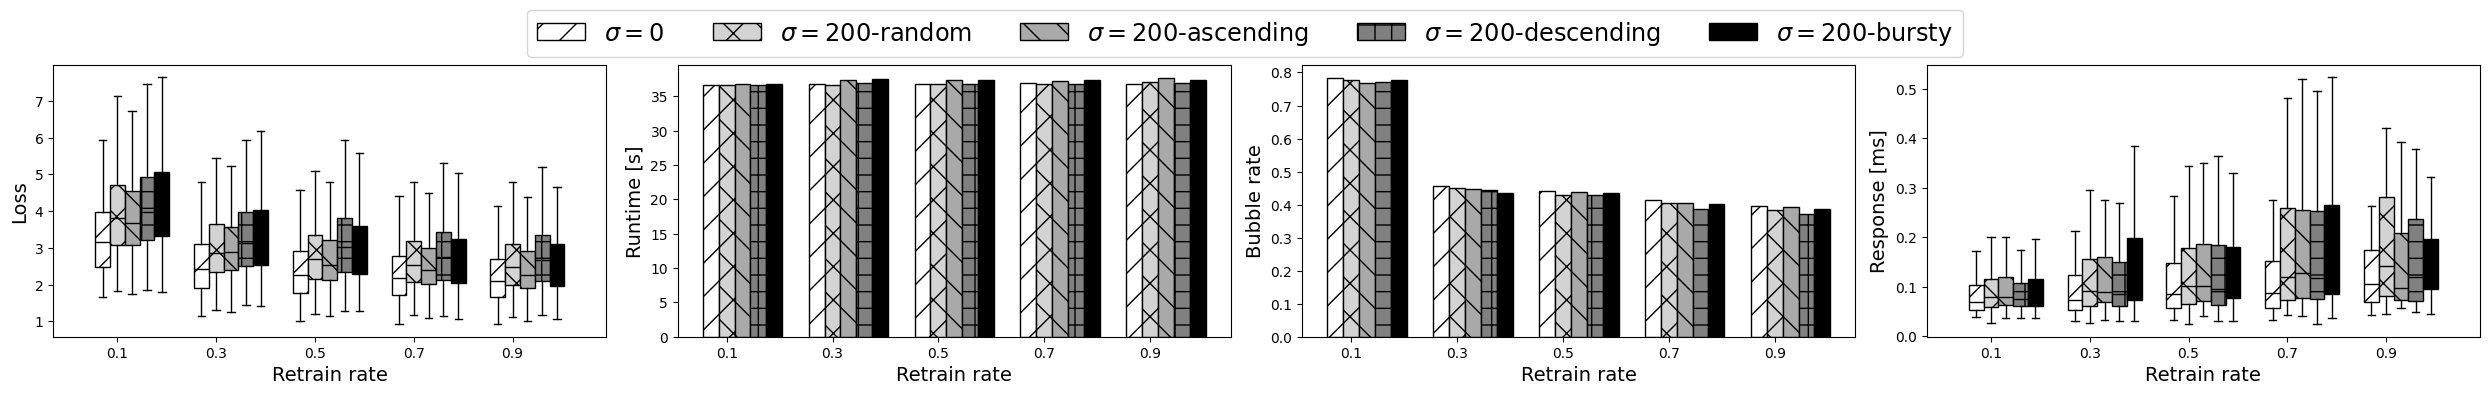

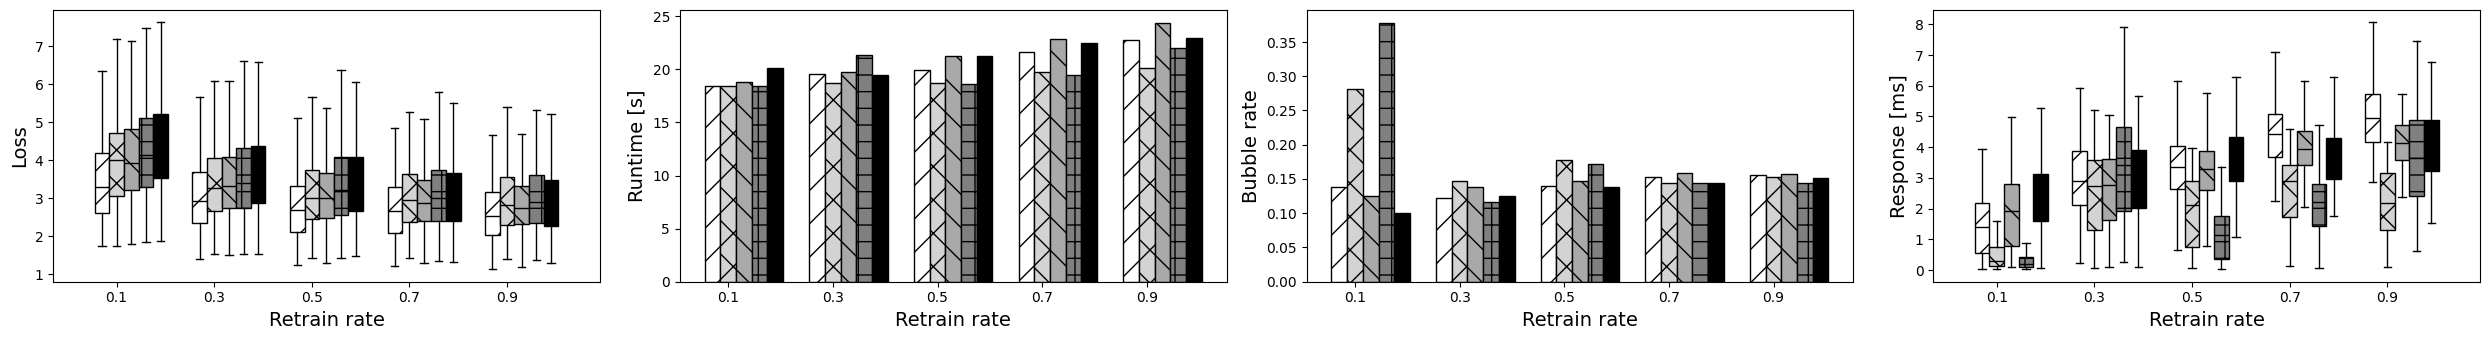

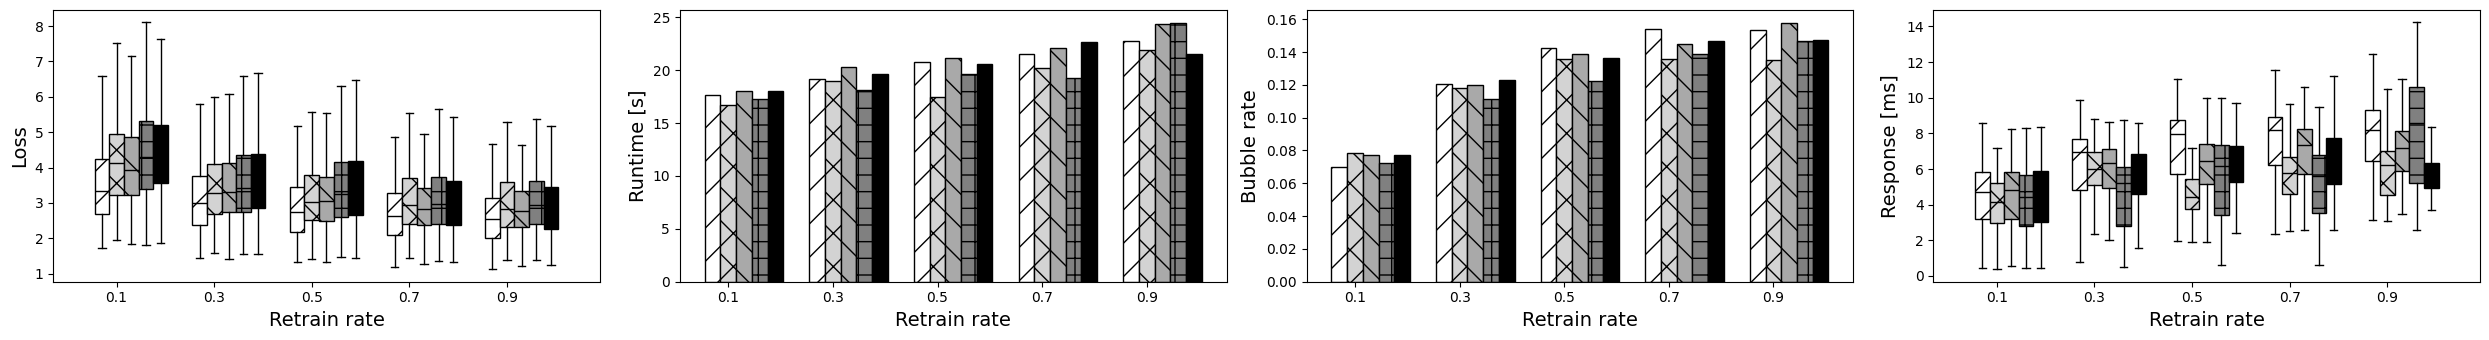

In [45]:
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=4, lambda_=10, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9])
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=4, lambda_=20, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)
plot_length_heterogeneity(model='DialoGPT-large', num_nodes=4, lambda_=30, length_heterogeneities=[0, 200], retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)

### Section 2.3.3 Active selection

In [35]:
def plot_active_selection(
    label='NaiveMix',  # 'Separate', 
    priority='FIFO', 
    load_balancing='random', 
    num_nodes=2, 
    models=['DialoGPT-small', 'DialoGPT-medium', 'DialoGPT-large'], 
    active_selection=None,
    selection_rates=[0.2, 0.4, 0.6, 0.8,],
    lambda_ = 10,
    retrain_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    legend = True,
):
    data = []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    for retrain_rate in retrain_rates:
        for model in models:
            for active_selection in selection_rates: # sigma
                # try:
                res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-{priority}_poisson-_hetero_default-random_{retrain_rate}-_active{active_selection}.json"))
                # except:
                #     res = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label]}-split{retrain_rate}-{priority}_poisson-_hetero_default-random_{retrain_rate}-_active{active_selection}.json"))
                res["retrain_rate"] = retrain_rate
                res["model"] = model
                # res['method'] = 'NaiveMix'
                res["Selection rate"] = active_selection
                data.append(res)
        
    data = pd.DataFrame(data)
    os.makedirs("figure", exist_ok=True)

    # Four metrics in subplots
    fig, axes = plt.subplots(1, 4, figsize=(25, 3.5))
    metrics = ['loss', 'end2end_latency', 'idles', 'user_response']
    colors = ['white', 'lightgray', 'darkgray', 'gray', 'black']  # Using only two methods
    methods = data["Selection rate"].unique().tolist()
    hatches = ['/', 'x', '\\', '+', '.']  # Using only two methods
    legend_patches = [mpatches.Patch(facecolor=colors[i], 
                                     hatch=hatches[i], 
                                     edgecolor='black', 
                                     label=r"$\beta=$"+f"{variance}") for i, variance in enumerate(methods)]

    for metric, ax in zip(metrics, axes):
        for i, (retrain_rate, group_data) in enumerate(data.groupby('retrain_rate')):
            positions = [i + offset*0.15 for offset in range(len(methods))]
            for variance in methods:
                variance_data = group_data[group_data['Selection rate'] == variance][metric].values
                box = ax.boxplot(variance_data, 
                                 positions=[positions[methods.index(variance)]], 
                                 widths=0.15, 
                                 patch_artist=True,
                                 boxprops=dict(facecolor=colors[methods.index(variance)], 
                                               hatch=hatches[methods.index(variance)]),
                                 medianprops=dict(color='black'),
                                 whiskerprops=dict(color='black'),
                                 capprops=dict(color='black'),
                                 showfliers=False)
        ax.set_xticks([i + 0.15 for i in range(len(retrain_rates))])
        ax.set_xticklabels(retrain_rates)
        ax.set_xlabel("Retrain rate", fontsize=14)
        ax.set_ylabel(METRIC2NAME[metric], fontsize=14)  # Make sure METRIC2NAME is defined before using

    if legend:
        fig.legend(handles=legend_patches, loc='upper center', ncol=len(methods), fontsize='large', bbox_to_anchor=(0.5, 1.1))
        
    plt.tight_layout()
    # hetero = length_heterogeneity.lstrip("_hetero")
    # active = active_selection.lstrip("_active")
    plt.savefig(f'figure/2-3-method={label}_nodes={num_nodes}_lambda={lambda_}.pdf', bbox_inches='tight')
    plt.show()

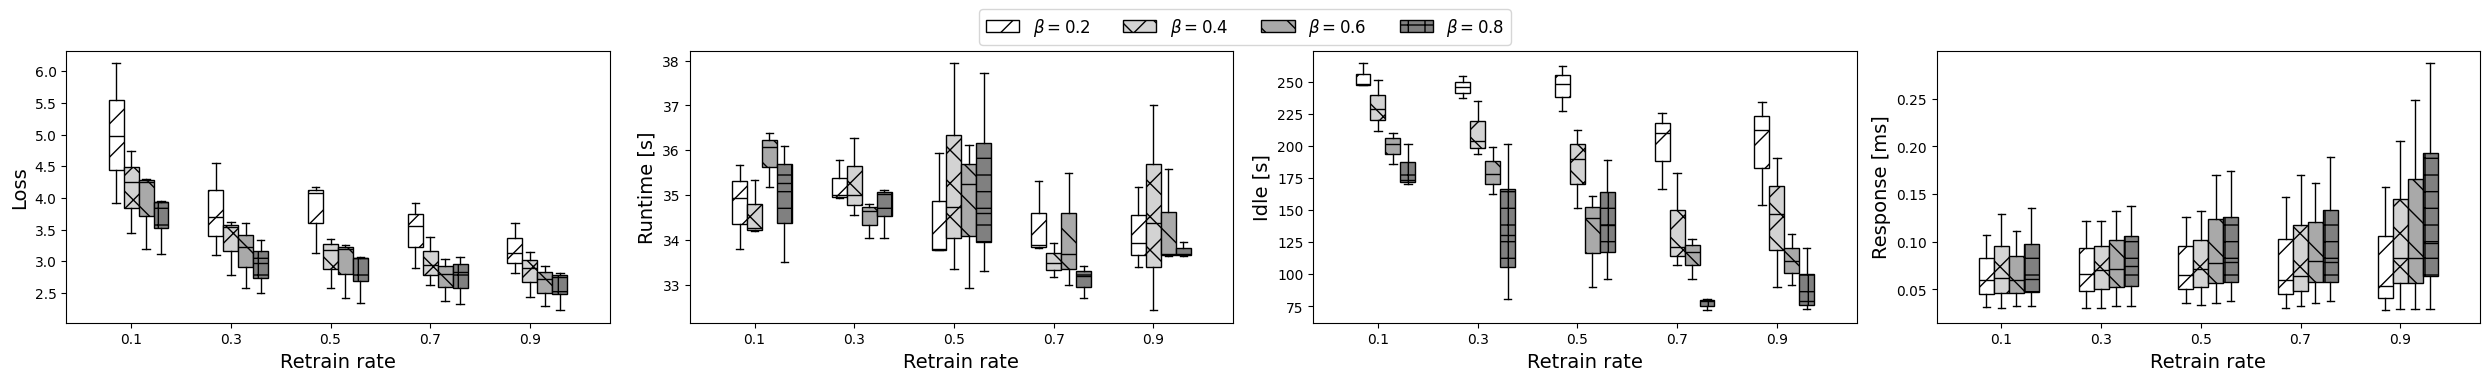

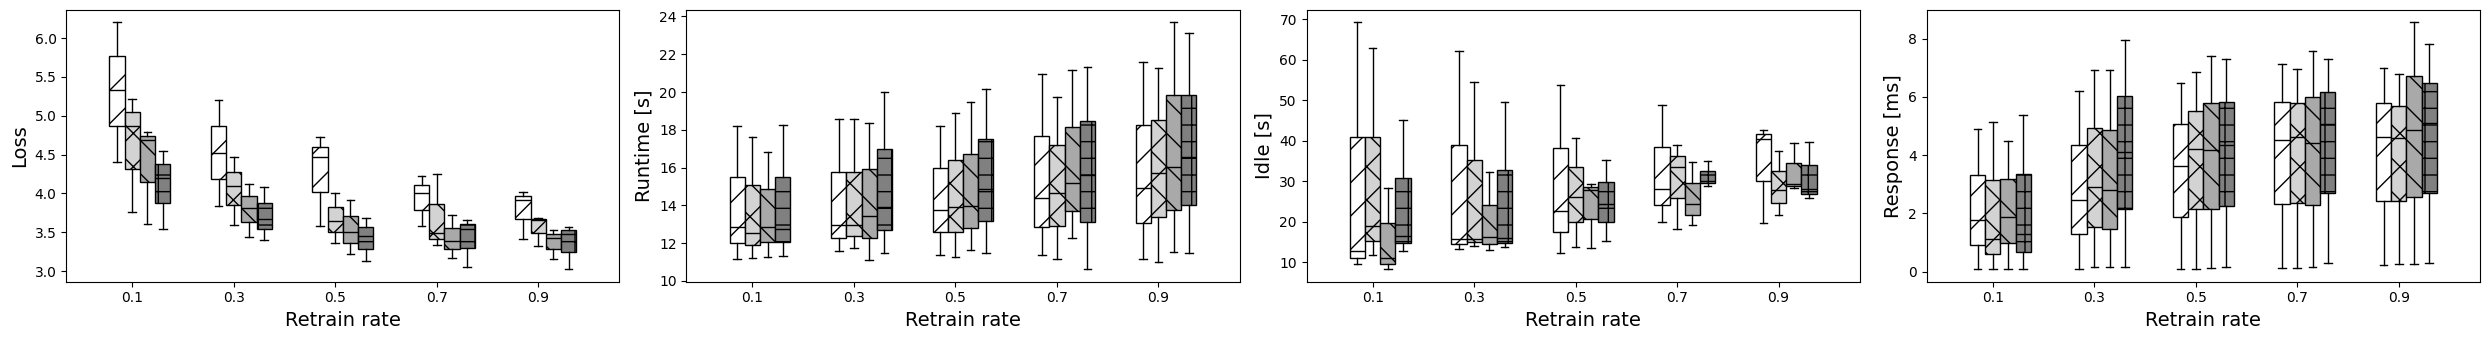

In [36]:
plot_active_selection(num_nodes=2, lambda_=10, retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9])
# plot_active_selection(num_nodes=2, lambda_=20, retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)
plot_active_selection(num_nodes=2, lambda_=30, retrain_rates=[0.1, 0.3, 0.5, 0.7, 0.9], legend=False)

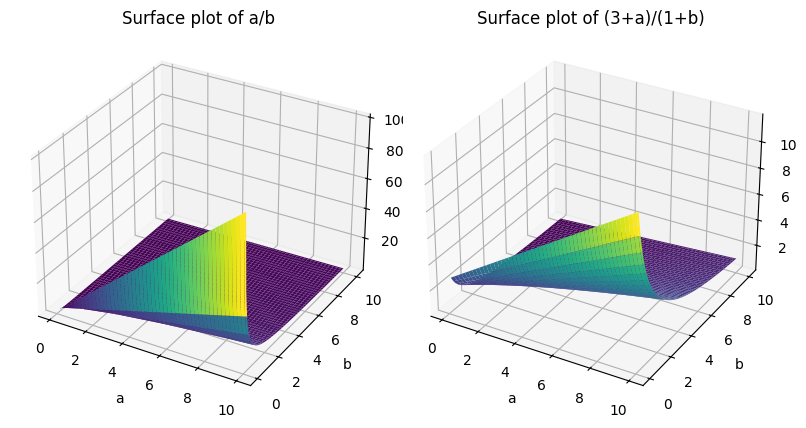

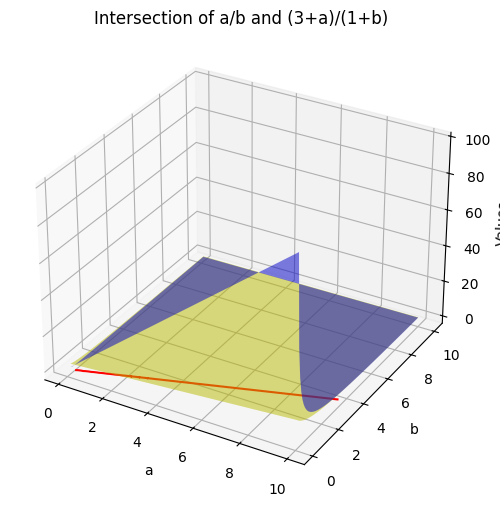

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the range for a and b
a_range = np.linspace(0.1, 10, 100)
b_range = np.linspace(0.1, 10, 100)

# Create a meshgrid for a and b
a, b = np.meshgrid(a_range, b_range)

# Calculate z values for both expressions
z1 = a / b
z2 = (3 + a) / (1 + b)
# Plot
fig = plt.figure(figsize=(8, 6))

# First subplot for a/b
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(a, b, z1, cmap='viridis')
ax1.set_title('Surface plot of a/b')
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_zlabel('a/b')

# Second subplot for (3+a)/(1+b)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(a, b, z2, cmap='viridis')
ax2.set_title('Surface plot of (3+a)/(1+b)')
ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_zlabel('(3+a)/(1+b)')

plt.tight_layout()
plt.show()

# Calculate the difference between the two expressions
z_diff = z1 - z2

# Plot both surfaces and the intersection line in a single 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface for a/b
ax.plot_surface(a, b, z1, alpha=0.5, rstride=100, cstride=100, color='blue', edgecolor='none', label='a/b')

# Plot surface for (3+a)/(1+b)
ax.plot_surface(a, b, z2, alpha=0.5, rstride=100, cstride=100, color='yellow', edgecolor='none', label='(3+a)/(1+b)')

# Plot intersection line (where z_diff == 0, approximated here as where the absolute difference is very small)
# We use a contour plot for this purpose
ax.contour(a, b, z_diff, levels=[0], colors='red')

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Values')
ax.set_title('Intersection of a/b and (3+a)/(1+b)')

plt.show()

# Identify conditions under which one expression is smaller than the other
# This approach is more qualitative, focusing on visualization. For a precise analysis, a numerical approach is needed.

# Note: The red line indicates points of intersection, i.e., where the two expressions are equal.
# Points above the red line on the blue surface indicate where a/b is greater, and vice versa for the yellow surface.


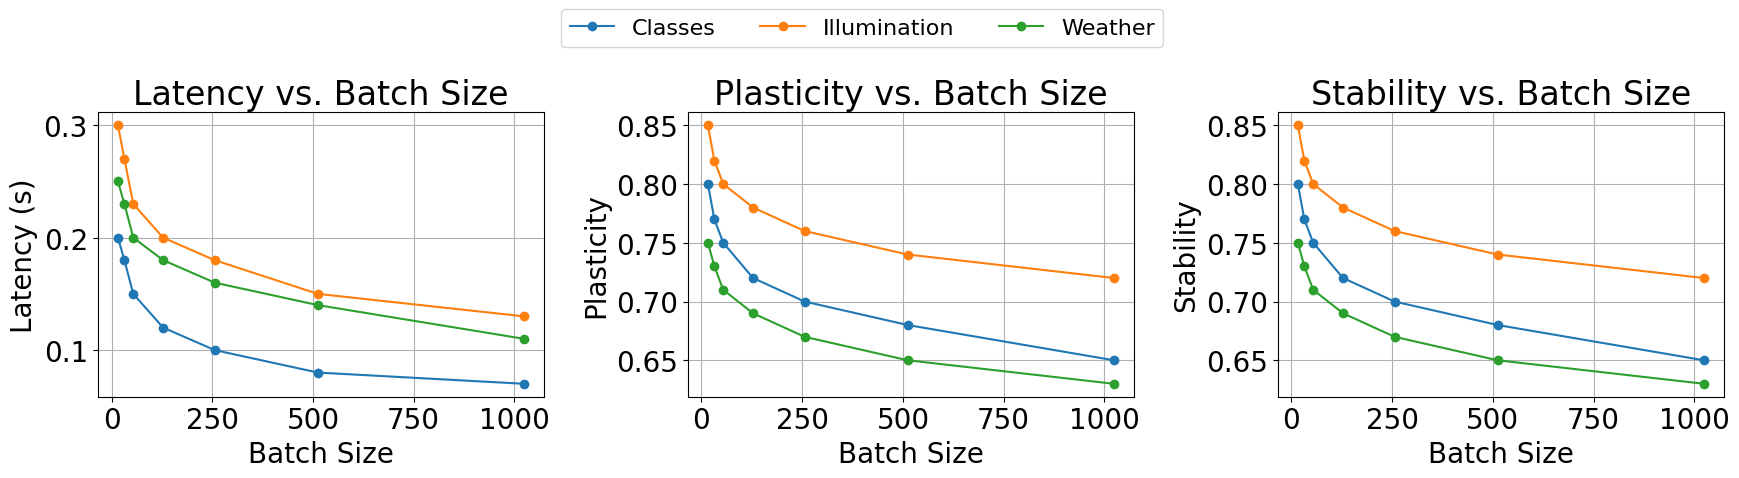

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20  # Adjust text size
# plt.rcParams['font.family'] = 'Times New Roman'  # Set font to Times New Roman
marker_style = "o"  # Set marker style
color_1 = "blue"
color_2 = "green"
color_3 = "red"

batch_sizes = [16, 32, 54, 128, 256, 512, 1024]

# Setup for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

latency_classes = [0.2, 0.18, 0.15, 0.12, 0.1, 0.08, 0.07]
latency_illumination = [0.3, 0.27, 0.23, 0.2, 0.18, 0.15, 0.13]
latency_weather = [0.25, 0.23, 0.2, 0.18, 0.16, 0.14, 0.11]

plasticity_classes = [0.8, 0.77, 0.75, 0.72, 0.7, 0.68, 0.65]
plasticity_illumination = [0.85, 0.82, 0.8, 0.78, 0.76, 0.74, 0.72]
plasticity_weather = [0.75, 0.73, 0.71, 0.69, 0.67, 0.65, 0.63]

stability_classes = [0.8, 0.77, 0.75, 0.72, 0.7, 0.68, 0.65]
stability_illumination = [0.85, 0.82, 0.8, 0.78, 0.76, 0.74, 0.72]
stability_weather = [0.75, 0.73, 0.71, 0.69, 0.67, 0.65, 0.63]

# Latency plot
axes[0].plot(batch_sizes, latency_classes, label="Classes", marker=marker_style)
axes[0].plot(batch_sizes, latency_illumination, label="Illumination", marker=marker_style)
axes[0].plot(batch_sizes, latency_weather, label="Weather", marker=marker_style)
axes[0].set_title("Latency vs. Batch Size")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Latency (s)")
# axes[0].legend()
axes[0].grid(True)

# Plasticity plot
axes[1].plot(batch_sizes, plasticity_classes, label="Classes", marker=marker_style)
axes[1].plot(batch_sizes, plasticity_illumination, label="Illumination", marker=marker_style)
axes[1].plot(batch_sizes, plasticity_weather, label="Weather", marker=marker_style)
axes[1].set_title("Plasticity vs. Batch Size")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Plasticity")
# axes[1].legend()
axes[1].grid(True)

# Stability plot
axes[2].plot(batch_sizes, stability_classes, label="Classes", marker=marker_style)
axes[2].plot(batch_sizes, stability_illumination, label="Illumination", marker=marker_style)
axes[2].plot(batch_sizes, stability_weather, label="Weather", marker=marker_style)
axes[2].set_title("Stability vs. Batch Size")
axes[2].set_xlabel("Batch Size")
axes[2].set_ylabel("Stability")
# axes[2].legend()
axes[2].grid(True)

# After plotting all lines in the subplots, add a single legend outside
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(l, []) for l in zip(*lines_labels)]
shared_labels = lines_labels[-1][1]

# Adjust the bbox_to_anchor and loc parameters to position the legend inside the figure boundary
fig.legend(lines, shared_labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=16)

fig.tight_layout(rect=[0, 0, 1, 0.9])
# plt.show()
plt.savefig("figure/batchsize.pdf")

In [23]:
import scipy
import numpy as np
scipy.stats.norm(13.5, 1).pdf(13.5)
# length_std = 0.01
# length_mean = 13.5
# task_length = 13.5
# (1 / (length_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((task_length - length_mean) / length_std) ** 2)

0.3989422804014327